# Predicting the Average Total Spend of Passengers in a New York City Taxi 

In this project, we are interested in predicting the average total payment made by passengers in a yellow taxi in New York City based on several input variables which will later be elucidated. In this project, we confine ourselves to a data set covering the month of January 2019. We use a publicly available data set which can be located through the following link:

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Alternatively, the .csv data file, along with the data dictionary, can be downloaded via the following link:

[yellow_tripdata_2019-01.csv.zip](https://cdn.fs.teachablecdn.com/dkaBwtmyQ0ehTSmzRkeE)

## Table of Contents

<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

## 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

We start by importing the Python libraries necessary for our analysis.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

## 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

We then import the data set as a pandas data frame. We use the concat function to fascilitate the possibility of combining data sets corresponding to different months in $2019$.

In [2]:
# January data set
taxi_jan_2019 = pd.read_csv("data/yellow_tripdata_2019-01.csv")

# Framework for merging February, March, ... data sets with the above
taxi_data = pd.concat([taxi_jan_2019])

To get a preliminary sense of the data set we are working with, we use the .shape function to determine the number of rows and series (columns) in the data frame, and the .head() function to visualise the first five rows of each series.

In [3]:
# Prints number of data items and series
print(taxi_data.shape)

# Displays first 5 rows of data frame
taxi_data.head()

(7667792, 18)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


Each row corresponds to a different yellow taxi trip. We see that there are over seven million trips to analyze, as well as eighteen series providing different types of information on each trip. 

# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In this section, we explore the data set in more detail. We look to condense our data set as much as possible (in line with the overall goal of the project), and to identify any erroneous or missing data in the set.

We first want to look at the series (columns) in our data set, and remove columns which are redundant in our analysis.

In [4]:
# Displays all series in data frame
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

By looking at the data dictionary for this data set (available in the .zip folder linked above), we can make judgements on which series are useful and which series are not useful in our analysis. Recall that we are looking to predict the average spend of passengers in a yellow taxi in New York.

Upon observation of the data dictionary, we see that the series "VendorID" and "store_and_fwd_flag" do not affect the expenditure of a passenger, and so these can be removed from the data frame. We also note that, for a given trip, the sum of the values corresponding to the series: "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", and "congestion_surcharge" gives the "total_amount" value, which is what we are aiming to predict. Thus, we can discount all of the series pertaining to the individual parts of this sum, and simply keep the "total amount series".

Given these observations, we can define a reduced data frame with fewer series.

In [5]:
# Defines a new data frame keeping only the specified columns from the original data frame
taxi_data = taxi_data[["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count",
                       "trip_distance", "RatecodeID", "PULocationID", "DOLocationID",
                       "payment_type", "total_amount"]]

Below is a visual of the reduced data frame.

In [6]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55


To get a better sense of the remaining data, we can construct histograms showing the series values for each trip.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C288C101C8>,
      dtype=object)

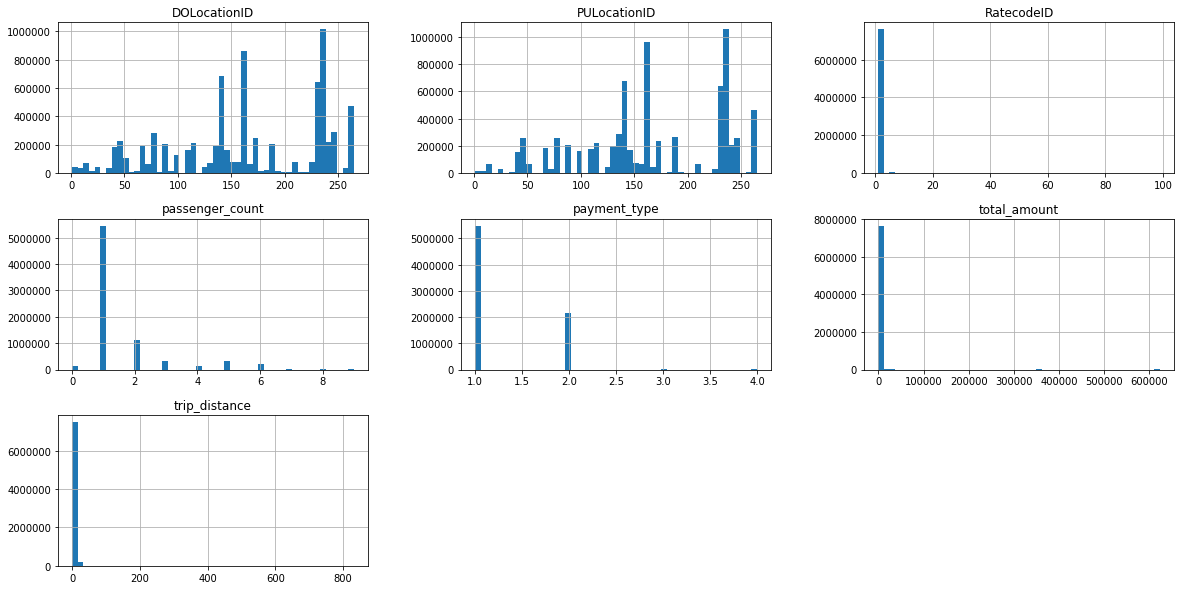

In [7]:
# Histograms for each series in taxi_data
taxi_data.hist(figsize=(20,10),bins=50)

From the histograms, we identify the following potential errors or anomolies in the data:

* We observe that there are records of trips with zero passengers in the data frame, which could be a data entry error.

* From the data dictionary, we know that the RatecodeID can only take a categorical integer value from $1$ to $6$ (inclusive), and so the presence of values $>6$ and $<100$ suggests a data entry error.

* There is evidence of a passenger paying over $£600000$ for a taxi ride, which is highly unlikely.

Let's look at the "RatecodeID" anomoly more closely. We can see below that there are $252$ instances in which a RatecodeID of $99$ has been recorded. This could be the result of human error during data entry, or a system error by the taxi company. In any case, since the trips which have been assigned a "RatecodeID" of $99$ account for $0.003\%$ of the total number of trips, they can be safely removed from the data set.

In [8]:
# Number of trips assigned with each RatecodeID
taxi_data["RatecodeID"].value_counts()

1     7430139
2      166090
5       54569
3       11801
4        4895
99        252
6          46
Name: RatecodeID, dtype: int64

Let's analyze the "total_amount" anomoly more closely by comparing these values against the row (trip) index in a scatter plot:

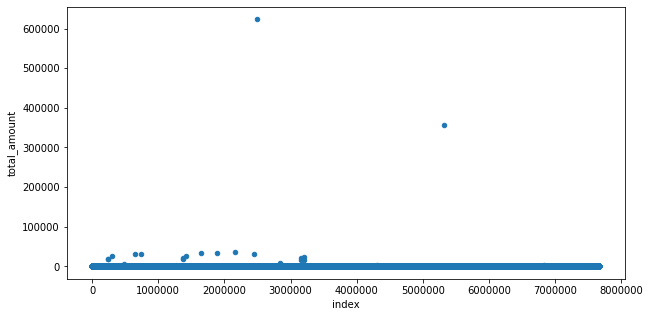

In [9]:
# Scatter plot of total amount for each trip
taxi_data.reset_index().plot(kind = "scatter", x = "index", y = "total_amount", figsize = (10,5))

We can see here that there are clearly some outlying total amounts, but these seem small in comparison to the total number of trips in the data set.

By changing the range of the plot, we can see that there are also negative values for the total amount, which is clearly not valid.

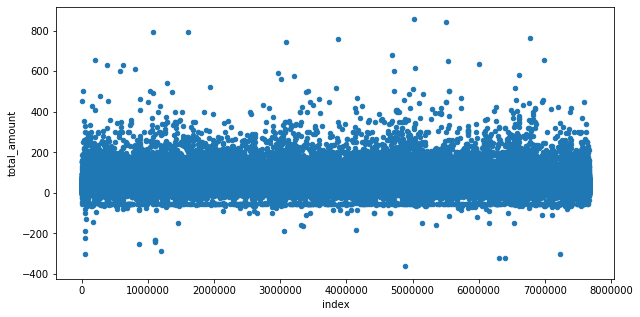

In [10]:
# Scatter plot of total amounts less than $1000
taxi_data[taxi_data["total_amount"] < 1000].reset_index().plot(kind = "scatter",
                                                               x = "index", y = "total_amount", figsize = (10,5))

Thus, we have two things to deal with here: the high outliers and the negative values. Let's look at the negative values first.

We want to see the number of negative values in relation to the size of the overall data set:

7131


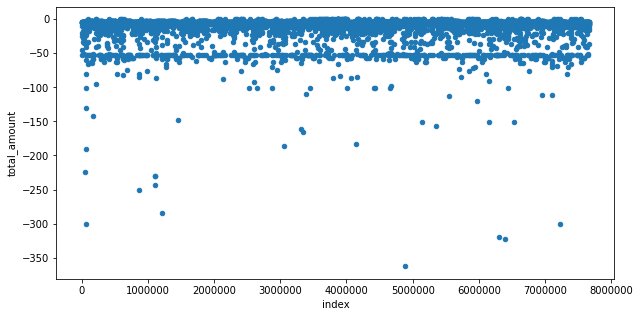

In [11]:
# Prints number of negative total amounts in data set
print(taxi_data[taxi_data["total_amount"]<0].shape[0])

# Scatter plot of negative total amounts
taxi_data[taxi_data["total_amount"]<0].reset_index().plot(kind = "scatter", x = "index", y = "total_amount", figsize = (10,5))

We can see that there are just over $7000$ negative values, which is small relative to the overall size of the data set. This suggests we could simply remove these negative values without causing much damage. However, let's do some additional investigations.

In [12]:
taxi_data[taxi_data["total_amount"]<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


One interesting feature of the above data frame for the negative values of "total_amount" is that the payment types seem to be 3 or 4. Let's see if this is the case for all negative values:

In [13]:
# Distribution of payment types amongst negative total amounts
taxi_data[taxi_data["total_amount"]<0]["payment_type"].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

We see that most of the negative values are associated with payment types 3 (no charge) and 4 (dispute). Let's analyze the trip distances corresponding to these negative values also:

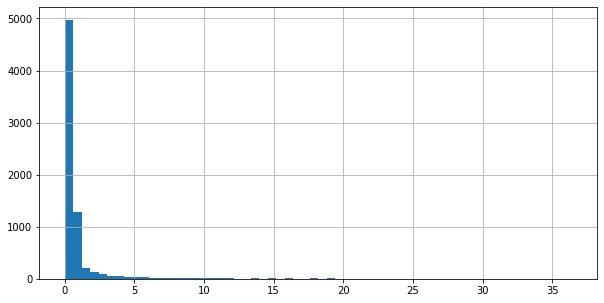

In [14]:
# Histogram of trip distances corresponding to negative total amounts
taxi_data[taxi_data["total_amount"]<0]["trip_distance"].hist(bins=60, figsize=(10,5))

There are a predominant number of trip distances of zero, so maybe the negative values are largely coming from confusion where a passenger gets into a taxi, but then decides they don't want the trip.

We have only looked at values of "total_amount" which are strictly less than zero. What about zero values? It would be strange for somebody to get a taxi and pay no fare, and such data may confuse our model. Let's analyze the occurance of such zero values.

In [15]:
taxi_data[taxi_data["total_amount"] == 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [16]:
# Distribution of payment types amongst zero total amounts
taxi_data[taxi_data["total_amount"]==0]["payment_type"].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

In [17]:
# Distribution of trip distances amongst zero total amounts
taxi_data[taxi_data["total_amount"]==0]["trip_distance"].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

We can see that the majority of the zero values are associated with zero distance trips. The strictly positive distance trips could be passengers that have dashed and not paid their fare.

Let's now look at the suspiciously large total amount values:

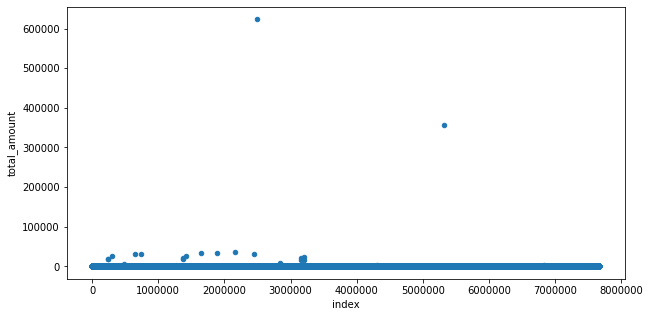

In [18]:
taxi_data.reset_index().plot(kind = "scatter", x = "index", y = "total_amount", figsize = (10,5))

We can see below that there are 56 total amount values above 500, which is far lower than the overall size of the data set. Therefore, we can be fairly certain that these high values are outliers which can be deleted from the data set.

In [19]:
# Number of total amounts above $500
taxi_data[taxi_data["total_amount"]>500].shape[0]

56

We need to decide on a threshold total amount above which to delete data points.

In [20]:
# Number of total amounts above $300
taxi_data[taxi_data["total_amount"]>300].shape[0]

307

In [21]:
# Number of total amounts above $200
taxi_data[taxi_data["total_amount"]>200].shape[0]

1166

In [22]:
# Number of total amounts above $100
taxi_data[taxi_data["total_amount"]>100].shape[0]

10832

Given the size of the overall dat set, it would seem from the above that 200 is a reasonable threshold. Let's double check this by calculating the mean total amount:

In [23]:
# Mean of total amounts
taxi_data["total_amount"].mean()

15.68222215901336

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In this section, we address the anomolies in the data set which were identified in section 2. Specifically, we delete anomolous values where appropriate, and we also investigate whether there are any missing values in the data set.

In the data exploration phase, we decided to delete all total amounts less than zero and greater than 200. This is what we do here:

In [24]:
# Deletes trips with total amounts less than $0 and greater than $200
taxi_data_filtered = taxi_data[(taxi_data["total_amount"]>=0) & (taxi_data["total_amount"]<200)]

In [25]:
# Number of trips in data set before deletion
print(taxi_data.shape[0])

# Number of trips in data set after deletion
taxi_data_filtered.shape[0]

7667792


7659490

We then check for missing values in the resulting data set:

In [26]:
# Sum of missing values for each series 
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

We see that there are no missing values. Therefore, at this stage, we do not need to deploy any filling or interpolation techniques on our data set.

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In this section, we transform the data set into a suitable format for feeding into a benchmark model. We modify the data types of each series, identify any anomolous data which was missed in the previous section, and aggregrate the data based on a chosen grouping of the entire set.

For convenience, we create a check point here for our data frame.

In [27]:
taxi_data_prepared = taxi_data_filtered.copy()

We first want to assess the current data types of each series in the data set, and make appropriate adjustments so that the data can be correctly feeded into the benchmark model.

In [28]:
# Types of data in each series
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

Currently, the pickup and dropoff date and time data values are strings. We need to covert these values to pandas datetime objects.

In [29]:
# Converts pickup date and time values to pandas datetime objects
taxi_data_prepared.loc[:, "tpep_pickup_datetime"] = pd.to_datetime(taxi_data_prepared.loc[:, "tpep_pickup_datetime"])

# Converts dropoff date and time values to pandas datetime objects
taxi_data_prepared.loc[:, "tpep_dropoff_datetime"] = pd.to_datetime(taxi_data_prepared.loc[:, "tpep_dropoff_datetime"])

We see also that "RatecodeID", "PULocationID", "DOLocationID" and "payment_type" values are currently integers. From the data dictionary, we know that these are all categorical variables. Therefore, to prevent interpretation of these as numerical values, we change their data types to string.

In [30]:
# Changes "RatecodeID" values from integer to string
taxi_data_prepared.loc[:, "RatecodeID"] = taxi_data_prepared["RatecodeID"].astype(str)

# Changes "PULocationID" values from integer to string
taxi_data_prepared.loc[:, "PULocationID"] = taxi_data_prepared["PULocationID"].astype(str)

# Changes "DOLocationID" values from integer to string
taxi_data_prepared.loc[:, "DOLocationID"] = taxi_data_prepared["DOLocationID"].astype(str)

# Changes "payment_type" values from integer to string
taxi_data_prepared.loc[:, "payment_type"] = taxi_data_prepared["payment_type"].astype(str)

We see now that the data values in each series are of the correct type.

In [31]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

The pickup date and time will have a large impact on the total amount. We want to granulate this series by creating series pertaining to the pickup date, year, month, day and hour.

In [32]:
# Creates new series for the transaction date
taxi_data_prepared["transaction_date"] = pd.to_datetime(taxi_data_prepared["tpep_pickup_datetime"].dt.date)

# Creates new series for the transaction year
taxi_data_prepared["transaction_year"] = taxi_data_prepared["tpep_pickup_datetime"].dt.year

# Creates new series for the transaction month
taxi_data_prepared["transaction_month"] = taxi_data_prepared["tpep_pickup_datetime"].dt.month

# Creates new series for the transaction day
taxi_data_prepared["transaction_day"] = taxi_data_prepared["tpep_pickup_datetime"].dt.day

# Creates new series for the transaction hour
taxi_data_prepared["transaction_hour"] = taxi_data_prepared["tpep_pickup_datetime"].dt.hour

On inspecting this granulated data set, we see there are some trips erroneously present which occurred in 2018.

In [33]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15


We see from the following histograms that there are also trips recorded with years as high as $2080$; these are clearly data entry errors.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C28D6C7608>,
      dtype=object)

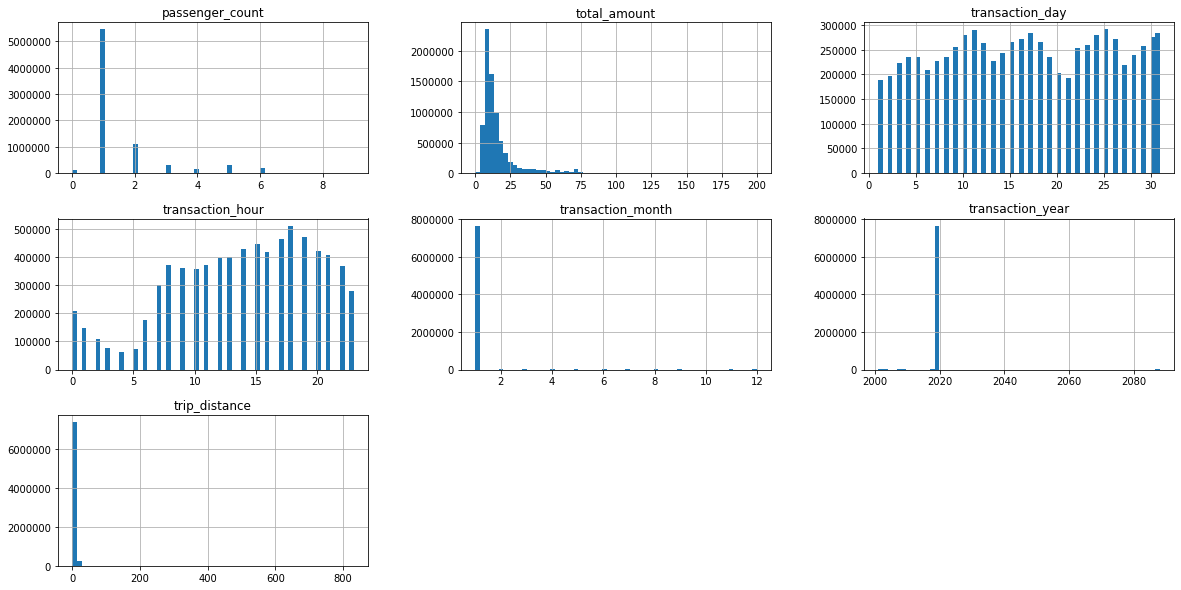

In [34]:
taxi_data_prepared.hist(bins=60, figsize = (20,10))

We therefore delete trips with a transaction year and month that isn't $2019$ and January, respectively.

In [35]:
# Restricts data set to trips occurring in 2019
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared["transaction_year"]==2019]

# Restricts data set to trips occuring in January 2019
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared["transaction_month"]==1]

At this point, we can choose to remove series which we believe will have little influence on our output of "total_amount". We separate the influential series into "categorical" and "numerical" columns based on the type of variable they are.

In [36]:
# Categorical variables
categorical_columns = ["PULocationID", "transaction_date", "transaction_month", "transaction_day", "transaction_hour"]

# Numerical variables
numerical_columns = ["trip_distance", "total_amount"]

# total remaining variables
all_needed_columns = categorical_columns + numerical_columns

We then create a new data frame containing only these reduced set of series.

In [37]:
# Reduced data frame
main_taxi_df = taxi_data_prepared[all_needed_columns]

print(main_taxi_df.shape)
main_taxi_df.head()

(7658954, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


We now want to aggregate the numerical values in the reduced data frame. We begin by grouping all transactions which occur within the same hour of the same date and with the same "PULocationID". We then aggregate the numerical data by taking the mean of the distances and total amounts of the trips in each group.

In [38]:
# Groups categorical variables and averages the numerical variables in each categorical group
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()

taxi_grouped_by_region

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,1,2019-01-01,1,1,2,0.00,21.800
1,1,2019-01-01,1,1,5,0.00,87.300
2,1,2019-01-01,1,1,6,0.00,80.300
3,1,2019-01-01,1,1,8,0.00,128.580
4,1,2019-01-01,1,1,10,16.90,43.245
...,...,...,...,...,...,...,...
102551,98,2019-01-31,1,31,18,16.66,58.060
102552,99,2019-01-18,1,18,18,1.66,9.800
102553,99,2019-01-26,1,26,8,0.42,6.000
102554,99,2019-01-30,1,30,7,2.87,18.050


We add a new column which details how many trips fall into each categorical group.

In [39]:
# Counts the number of trips in each categorical group
taxi_grouped_by_region["count_of_transactions"] = main_taxi_df.groupby(categorical_columns).count().reset_index()["total_amount"]

print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(102556, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

We now construct a benchmark model based on the current data set.

In [40]:
# Checkpoint for data set
data_for_benchmark_model = taxi_grouped_by_region.copy()

We define the input and output variables variables here. Note that we remove "trip_distance" as an input variable. This is because trip_distance and total_amount are directly correlated, and the distance of the trip would not be known a priori. Therefore, it cannot contribute to our predictory model.

In [41]:
categorical_features_benchmark = ["PULocationID", "transaction_month", "transaction_day", "transaction_hour"]
numerical_features_benchmark = ["trip_distance"]

# Input variables
input_features_benchmark = categorical_features_benchmark

# Output variable
output_feature_benchmark = "total_amount"

## 5.1 Train-test split

We now split the data set into a training set and a testing set. The former will train our model to make predictions, whilst the latter will be used to evaluate the accuracy of the model compared with the original data. Given the size of our original data set, we let the testing set be $1/3$ the size of the original data set.

In [42]:
# Imports data splitting tool
from sklearn.model_selection import train_test_split

# Input for benchmark model
x_bench = data_for_benchmark_model[input_features_benchmark]

# Output data values
y_bench = data_for_benchmark_model[output_feature_benchmark]

# Convert categorical input variables into dummy variables
X_bench = pd.get_dummies(x_bench)

# Splits input and output data sets into testing and training sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size = 0.33, random_state = 42)

## 5.2 Fit a model to the data

We use a Decision Tree machine learning model here, which belongs to a family of supervised learning algorithms. One notable advantage of the Decision Tree is that it can deal with both classification __and__ regression problems (i.e. problems where the output variable is either discrete or continuous).

In the context of our problem, the Decision Tree will create a model which predicts the value of the "total_amount" by learning simple decision rules inferred from previous training data. Since our output variable is continuous, we will adopt the continuous variable decision tree model "DecisionTreeRegressor".

In [43]:
# Imports DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# DecisionTreeRegressor function
tree = DecisionTreeRegressor(max_depth = 10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## 5.3 Model Evaluation

We now assess the accuracy of the predictions of this benchmark model compared with the testing output data. To do this, we consider several regression metrics. Firstly, let $n$ be the number of trips in the data set, and $y_{t}^{(i)}$ and $y_{p}^{(i)}$ be the test and predicted total_amount values, respectively, for the $i^{th}$ trip, where $i = 1, 2, \ldots n$. Then, we measure the performance of the model based on the following metric:

__Mean absolute error__

$\frac{1}{n}\sum_{i = 1}^{n}|y_t^{(i)} - y_p^{(i)}|$

__Mean squared error__

$\frac{1}{n}\sum_{i = 1}^{n}(y_t^{(i)} - y_p^{(i)})^2$

__Coefficient of determination__

$1 - \frac{\sum_{i = 1}^{n}\left(y_t^{(i)} - y_p^{(i)}\right)^2}{\sum_{i = 1}^{n}\left(y_t^{(i)} - \bar{y}_t\right)^2},\,\,\,\,\,\,\,\,$where$\,\,\,\,\,\,\,\,$ $\bar{y}_{t} = \sum_{i=1}^{n}y_{t}^{(i)}$.  

In [44]:
# Decision Tree Regression model
model_at_hand = tree

# Predictions for total_amount from feeding test input data into the model
y_pred_b = model_at_hand.predict(X_test_b)

# Mean absolute error
from sklearn.metrics import mean_absolute_error

# Mean squared error
from sklearn.metrics import mean_squared_error

# r^2 value
from sklearn.metrics import r2_score

# square root function
from math import sqrt

# Mean absolute error between test output value and model-predicted output value
print("mean abs. error:", mean_absolute_error(y_test_b, y_pred_b))

# Mean squared error between test output value and model-predicted output value
print("mean sqd. error:", mean_squared_error(y_test_b, y_pred_b))

# r^2 value
print("r2:", r2_score(y_test_b, y_pred_b))

mean abs. error: 9.77820556436191
mean sqd. error: 217.2393744533513
r2: 0.22476844306735888


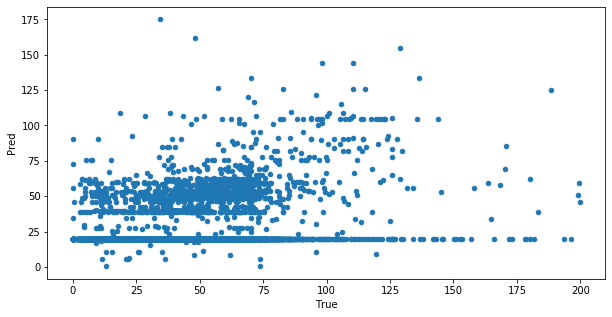

In [45]:
# Data frame with true and predicted output value series
data = {"True": y_test_b, "Pred": y_pred_b}
results = pd.DataFrame(data)

# relationship between true and predicted values
results.plot(kind = "scatter", x = "True", y = "Pred", figsize = (10, 5))

For high model performance, we seek a MAE and MSE close to zero, and a coefficient of determination close to one. A coefficient of determination equal to one indicates perfect agreement between the true and predicted output values. Clearly, we can see that neither of these criteria are met with our benchmark model. Therefore, some refinement and feature engineering is required to improve model performance. 

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

In this section, we modify existing input features, and engineer new input features, in order to improve the performance of our model.

We begin by creating a checkpoint for our existing data set.

In [46]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


In [47]:
# Checkpoint for data set
data_with_new_features = taxi_grouped_by_region.copy()

## 6.1 Date related features

It is logical that the total_amount will be influenced by whether the trip occurs on a weekday or a weekend, and also whether the trip occurs on a US national holiday. On weekends or holidays, individuals may be going out with friends or family, and may not want to take their car. Therefore, they will be more likely to take a taxi. Thus, higher average total amounts in a given hour of a weekend day or holiday could be possible.

We can add a "transaction_week_day" column which marks the day number corresponding to each trip ($0$ to $6$ corresponds to Monday to Sunday).

In [48]:
# Creates new column marking weekday of each trip
data_with_new_features["transaction_week_day"] = data_with_new_features["transaction_date"].dt.weekday

We can then add a Boolean feature which tells us whether a given trip occurs on a weekend or not.

In [49]:
# Function determining whether a given day occurs on the weekend
def weekend(x):
    return True if x == 5 or x == 6 else False

# Boolean feature telling us whether a given trip occurs on a weekend
data_with_new_features["weekend"] = data_with_new_features["transaction_week_day"].apply(weekend)

The same logic applies to holidays. We can import the US holiday calendar through pandas, and create a Boolean feature telling us whether a given trip occurs on a holiday.

In [50]:
# Imports US national holiday calendar
from pandas.tseries.holiday import USFederalHolidayCalendar

# Defines series of US national holidays in 2019
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start = "2018", end = "2020").date

# Boolean series stating whether each trip date is a national holiday
data_with_new_features["is_holiday"] = data_with_new_features["transaction_date"].isin(holidays)

## 6.2 Borough information

We can also add a series which details the borough associated with each pick up location ID.

In [51]:
# Data set for taxi zones
zone_lookup = pd.read_csv("data/taxi_zone_lookup.csv")

# Reduces taxi zone lookup set to two series
zone_lookup = zone_lookup[["LocationID", "Borough"]]

# Converts location ID values to strings
zone_lookup["LocationID"] = zone_lookup["LocationID"].astype(str)

zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


We can merge our original data set with the zone_lookup data set.

In [52]:
# Combines original data set with zone_lookup
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on = "PULocationID", right_on = "LocationID", how = "left")
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,1,EWR
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,1,EWR
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,1,EWR
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,1,EWR
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,1,EWR


In [53]:
data_with_new_features["Borough"].value_counts()

Manhattan        45309
Brooklyn         23633
Queens           22002
Bronx             9586
Unknown           1453
Staten Island      302
EWR                271
Name: Borough, dtype: int64

## 6.3 Weather related features

Weather may also influence the total_amount value. For instance, if it is cold or raining, people are far more likely to take a taxi than walk. We can read a weather database for NYC into the notebook. This gives information on weather features such as temperature, humidity, wind speed etc. Here is the link to this data set:

[nyc_weather.csv](https://cdn.fs.teachablecdn.com/3ybIPYgSQbGSnY40pfHk)

In [54]:
# Reads in nyc_weather.csv 
nyc_weather = pd.read_csv("data/nyc_weather.csv")
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2019 22:00,6.1,65,6,100%.,0.3
1,31.12.2019 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2019 16:00,7.2,66,5,50%.,NaN
3,31.12.2019 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2019 10:00,4.4,83,2,100%.,Trace of precipitation


We see below that we need to adjust the data types in some series. For instance, date and time objects should be changed to pandas datetime objects, and cloud cover and amount of precipitation objects should be changed to floats.

In [55]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object

We want to convert each cloud cover percentage value or range to a single float value.

In [56]:
nyc_weather["cloud cover"].value_counts()

70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: cloud cover, dtype: int64

We also need a numerical representation for "Trace of precipitation" in the "amount of precipitation column".

In [57]:
nyc_weather["amount of precipitation"].value_counts()

Trace of precipitation    266
0.3                        61
2.0                        49
1.0                        45
0.5                        42
0.8                        42
4.0                        33
5.0                        24
3.0                        23
6.0                        19
8.0                        13
7.0                        13
9.0                        11
10.0                       10
13.0                        7
12.0                        7
15.0                        6
11.0                        5
16.0                        3
29.0                        2
14.0                        2
22.0                        2
35.0                        1
17.0                        1
30.0                        1
63.0                        1
24.0                        1
18.0                        1
25.0                        1
68.0                        1
34.0                        1
21.0                        1
20.0                        1
Name: amou

We need to analyse the number of missing values in each series of nyc_weather.

In [58]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
dtype: int64

We are going to assign a value of "0.1" to "Trace of precipitation", and interpolate to fill the missing values.

In [59]:
# Assigns 0.1 to "Trace of precipitation"
nyc_weather["amount of precipitation"] = nyc_weather["amount of precipitation"].replace("Trace of precipitation", 0.1)

# Converts amount of precipitation objects to floats
nyc_weather["amount of precipitation"] = nyc_weather["amount of precipitation"].astype(float)

# Interpolation to fill missing values
nyc_weather["amount of precipitation"].interpolate(inplace = True)

We assign numerical values to each percentage value or range for cloud cover, and associate "Sky obscured by fog and/or other meteorological phenomena" with $100\%$ cloud cover. We interpolate to fill the missing values.

In [60]:
# Assigns numerical values to cloud cover percentages
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("70 – 80%.", 0.7)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("100%.", 1)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("20–30%.", 0.3)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("50%.", 0.5)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("no clouds", 0)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("70 - 80%.", 0.7)
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].replace("Sky obscured by fog and/or other meteorological phenomena.", 1)

# Converts cloud cover objects to floats
nyc_weather["cloud cover"] = nyc_weather["cloud cover"].astype(float)

# Interpolation to fill missing values
nyc_weather["cloud cover"].interpolate(inplace = True)

We also need to change the date and time objects to pandas datetime objects, and generate additional "month", "day" and "hour" series.

In [61]:
nyc_weather.dtypes

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation    float64
dtype: object

In [62]:
nyc_weather.loc[:, "date and time"] = pd.to_datetime(nyc_weather.loc[:, "date and time"])
nyc_weather["hour"] = nyc_weather["date and time"].dt.hour
nyc_weather["month"] = nyc_weather["date and time"].dt.month
nyc_weather["day"] = nyc_weather["date and time"].dt.day

In [63]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,2019-12-31 22:00:00,6.1,65,6,1.0,0.300000,22,12,31
1,2019-12-31 19:00:00,6.7,71,5,0.7,0.233333,19,12,31
2,2019-12-31 16:00:00,7.2,66,5,0.5,0.166667,16,12,31
3,2019-12-31 13:00:00,6.1,76,3,1.0,0.100000,13,12,31
4,2019-12-31 10:00:00,4.4,83,2,1.0,0.100000,10,12,31


Now, we merge the original data set with nyc_weather.

In [64]:
nyc_taxi_with_weather = data_with_new_features.merge(nyc_weather, left_on = ['transaction_month','transaction_day','transaction_hour'], right_on = ['month','day','hour'], how='left')

print(nyc_taxi_with_weather.shape)
nyc_taxi_with_weather.head()

(102556, 22)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,...,EWR,2019-01-01 10:00:00,15.6,62.0,11.0,0.7,0.473333,10.0,1.0,1.0


In [65]:
# Removes unecessary series
nyc_taxi_with_weather = nyc_taxi_with_weather.drop(['date and time','hour','month','day'], axis=1)
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,1,2019-01-01,1,1,2,0.0,21.800,1,1,False,True,1,EWR,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,1,1,5,0.0,87.300,1,1,False,True,1,EWR,NaN,NaN,NaN,NaN,NaN
2,1,2019-01-01,1,1,6,0.0,80.300,1,1,False,True,1,EWR,NaN,NaN,NaN,NaN,NaN
3,1,2019-01-01,1,1,8,0.0,128.580,2,1,False,True,1,EWR,NaN,NaN,NaN,NaN,NaN
4,1,2019-01-01,1,1,10,16.9,43.245,4,1,False,True,1,EWR,15.6,62.0,11.0,0.7,0.473333


Since the nyc_weather data set is constructed in three-hourly periods, and the original data set is in hourly periods, the combined data set contains missing values in the weather features series.

In [66]:
nyc_taxi_with_weather.isna().sum()

PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
LocationID                     0
Borough                        0
temperature                68371
humidity                   68371
wind speed                 68371
cloud cover                68371
amount of precipitation    68371
dtype: int64

To rectify this, we put the transaction date and hour in chronological order, and then interpolate to fill the missing weather-related values.

In [67]:
# Puts transaction_date and transaction_hour values in chronological order
nyc_taxi_with_weather = nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index().drop('index',axis=1)

In [68]:
nyc_taxi_with_weather = nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather = nyc_taxi_with_weather.fillna(method='bfill')

# No remaining missing values
nyc_taxi_with_weather.isna().sum()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
LocationID                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64

In [69]:
nyc_taxi_with_weather.tail()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,LocationID,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
102551,88,2019-01-31,1,31,23,5.196607,27.126607,56,3,False,False,88,Manhattan,-9.4,32.0,7.0,0.3,0.164286
102552,89,2019-01-31,1,31,23,1.750000,9.050000,2,3,False,False,89,Brooklyn,-9.4,32.0,7.0,0.3,0.164286
102553,90,2019-01-31,1,31,23,2.967793,16.049718,213,3,False,False,90,Manhattan,-9.4,32.0,7.0,0.3,0.164286
102554,94,2019-01-31,1,31,23,0.590000,5.800000,1,3,False,False,94,Bronx,-9.4,32.0,7.0,0.3,0.164286
102555,97,2019-01-31,1,31,23,3.215263,15.602105,19,3,False,False,97,Brooklyn,-9.4,32.0,7.0,0.3,0.164286


# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

We now train the model based on our refined data set.

In [70]:
# Checkpoint for data set
data_for_model = nyc_taxi_with_weather.copy()

As before, we define the categorical and numerical variables, as well as the input and output variables.

In [71]:
categorical_features = ["PULocationID", "transaction_month", "transaction_day", "transaction_hour", 
                        "transaction_week_day", "weekend","is_holiday", "Borough"]
numerical_features = ["temperature", "humidity", "wind speed","cloud cover","amount of precipitation"]
input_features = categorical_features + numerical_features
output_feature = "total_amount"

## 7.1 Train-test split

We apply the same train-test split as previously.

In [72]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[output_feature]

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 7.1. Decision tree <a id='decision_tree'></a>

We implement a decision tree regressor model as before. The reason we select a maximum depth of 10 for our tree will be elucidated later.

In [73]:
from sklearn.tree import DecisionTreeRegressor 

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [74]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.537992432249894
mean_squared_error 196.68843237117804
root_mean_squared_error 14.02456531843957
r2 0.30666097299302486


We observe that the regression metrics are certainly improved from their counterparts for the benchmark model. Thus, our feature engineering has had some positive impact on the model performance.

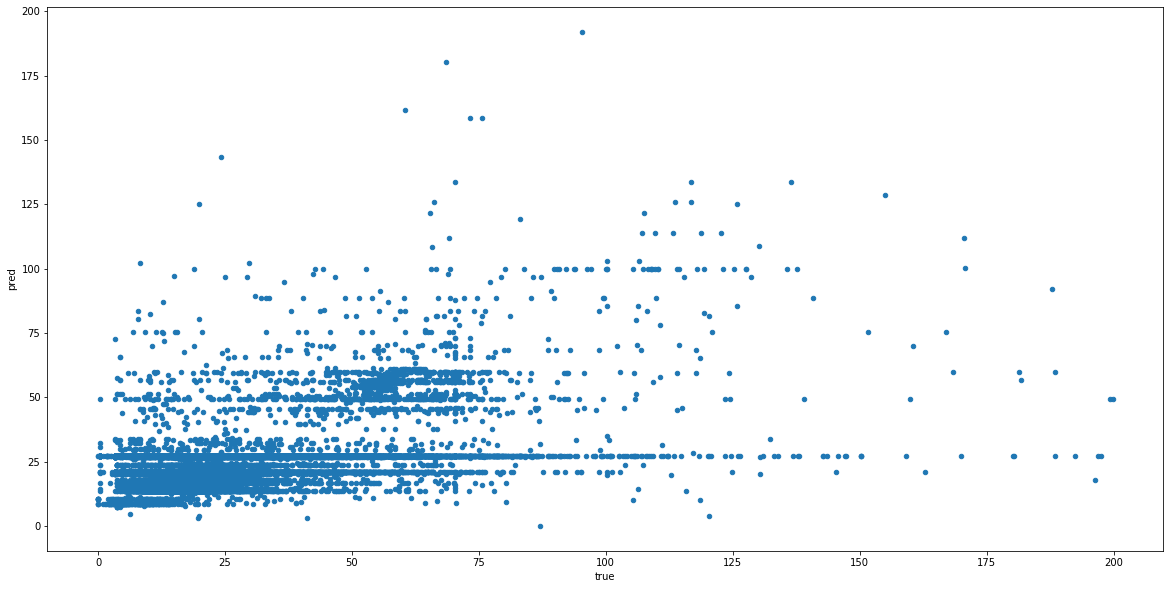

In [75]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 7.1.1 Overfitting

Overfitting commonly occurs in decision trees when the depth of the tree is too high. In such cases, the decision tree model fits the training data too well, and is unable to suitably generalise to the testing data. Thus, we must carefully choose the depth of the decision tree to provide sufficiently levels of accuracy in fitting with the training and testing data.

Let's analyze the dependence of the root mean squared error between the observed and predicted output values on the maximum tree depth. 

In [76]:
X_train_OF = X_train
y_train_OF = y_train

X_test_OF = X_test
y_test_OF = y_test

In [77]:
# Blank data frame comparing 
rmse_scores = {'max_depth':[] ,'rmse_train':[], 'rmse_test':[]}

for md in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 150]:
    print(md)
    decision_tree_OF = DecisionTreeRegressor(max_depth=md)
    decision_tree_OF.fit(X_train_OF, y_train_OF)
    model_at_hand_OF = decision_tree_OF
    y_pred_train = model_at_hand_OF.predict(X_train_OF)
    rmse_train = sqrt(mean_squared_error(y_train_OF, y_pred_train))
    y_pred_test = model_at_hand_OF.predict(X_test_OF)
    rmse_test = sqrt(mean_squared_error(y_test_OF, y_pred_test))
    rmse_scores["max_depth"].append(md)
    rmse_scores["rmse_train"].append(rmse_train)
    rmse_scores["rmse_test"].append(rmse_test)

2
5
8
10
15
20
30
50
70
100
150


In [78]:
rmse_scores_ = pd.DataFrame.from_dict(rmse_scores)
rmse_scores_

,max_depth,rmse_train,rmse_test
0,2,14.951628,15.174393
1,5,14.122533,14.497210
2,8,13.523693,14.120358
3,10,13.139617,14.066694
4,15,12.048870,14.340389
5,20,11.099972,14.547226
6,30,9.498728,15.115106
7,50,5.425101,16.627770
8,70,1.124847,17.416636
9,100,0.000005,17.364511


Text(0, 0.5, 'root mean squared error')

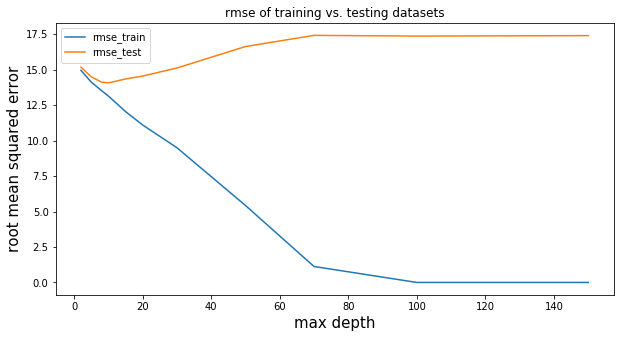

In [79]:
ax = rmse_scores_.plot(figsize = (10,5), x = "max_depth", title="rmse of training vs. testing datasets")
ax.set_xlabel("max depth", fontsize=15)
ax.set_ylabel("root mean squared error", fontsize=15)

## 7.2. Random forest <a id='random_forest'></a>

In [80]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()
rando_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [81]:
model_at_hand = rando_model

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 7.4294023795029265
mean_squared_error 175.08640528455706
root_mean_squared_error 13.232021965087462
r2 0.3828094696842358


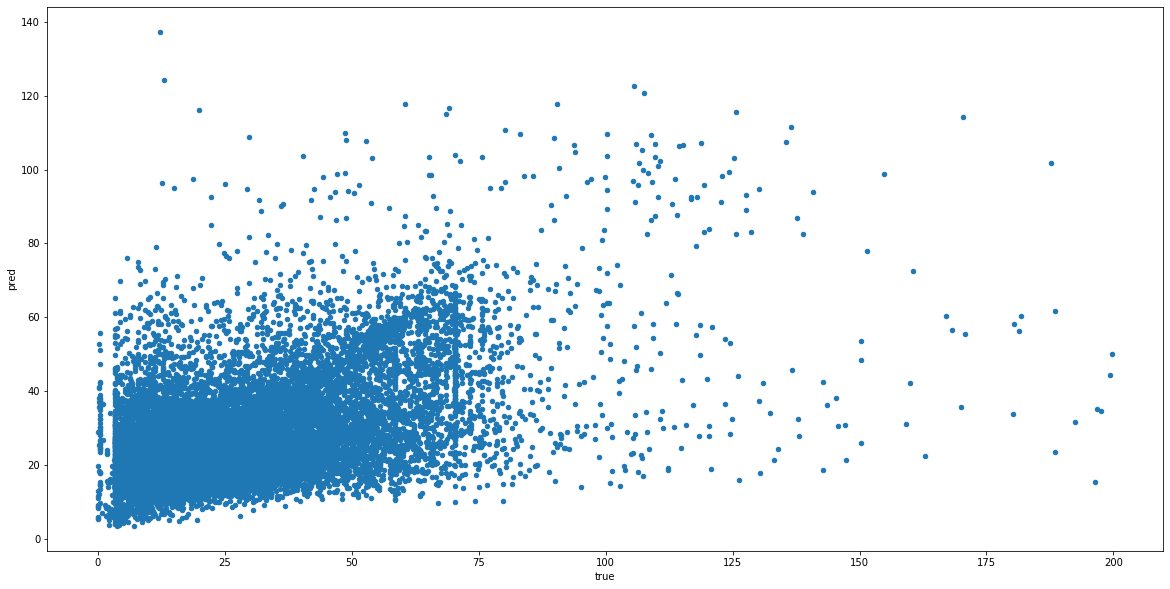

In [82]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 7.3. Gradient boosting <a id='comparing_algorithm_performances'></a>

In [83]:
from sklearn.ensemble import GradientBoostingRegressor

gradBooster = GradientBoostingRegressor()
gradBooster.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
model_at_hand = gradBooster

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 8.388105307181757
mean_squared_error 178.98082156535364
root_mean_squared_error 13.378371409306652
r2 0.36908140869795436


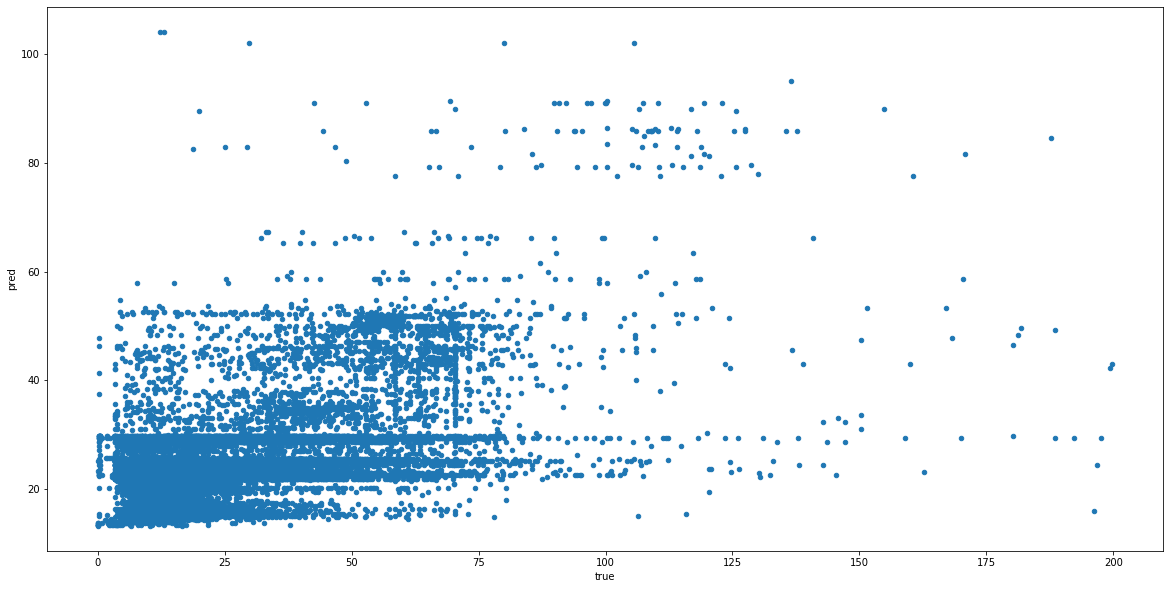

In [85]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')